In [ ]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:2 http://deb.debian.org/debian buster InRelease [122 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [318 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,911 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8,796 B]
Fetched 8,477 kB in 1s (5,913 kB/s)



32 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil5

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 32.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


#### Import Libraries 

In [ ]:
import numpy as np
import pickle
from os import listdir
import os
import cv2
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### Define Basic Variable which include Number of Epochs, Image size, etc 

In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/work/images/images'
width=256
height=256
depth=3

#### Function to convert image to a numpy array

In [ ]:
 def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

#### Load all the images as well as thier labels

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for fish_species_folder in root_dir:
            fish_species_list = os.listdir(f'{directory_root}/{fish_species_folder}')
            for image in fish_species_list[:500]:
                image_directory = f"{directory_root}/{fish_species_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(fish_species_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
image_size

3432

#### Use LabelBinarizer to get all the differnet label realted to fish species

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform_Fina_1.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

#### Define the model as Sequential and add different layers

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Bat ekchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...
/shared-libs/python3.7/py/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Train the Model for 50 epoch and print the test loss, test accuracy, validation loss, validation accuracy

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
Epoch 1/50
85/85 [==============================] - 283s 3s/step - loss: 0.6705 - accuracy: 0.2105 - val_loss: 2.4932 - val_accuracy: 0.1383
Epoch 2/50
85/85 [==============================] - 276s 3s/step - loss: 0.4651 - accuracy: 0.2717 - val_loss: 1.6517 - val_accuracy: 0.2009
Epoch 3/50
85/85 [==============================] - 278s 3s/step - loss: 0.4746 - accuracy: 0.3137 - val_loss: 0.5618 - val_accuracy: 0.2373
Epoch 4/50
85/85 [==============================] - 277s 3s/step - loss: 0.4031 - accuracy: 0.4018 - val_loss: 0.4741 - val_accuracy: 0.2504
Epoch 5/50
85/85 [==============================] - 275s 3s/step - loss: 0.3630 - accuracy: 0.4714 - val_loss: 0.4885 - val_accuracy: 0.2868
Epoch 6/50
85/85 [==============================] - 275s 3s/step

KernelInterrupted: Execution interrupted by the Jupyter kernel.

#### Plot the Training and Validation Accuracy and loss and print the accuracy

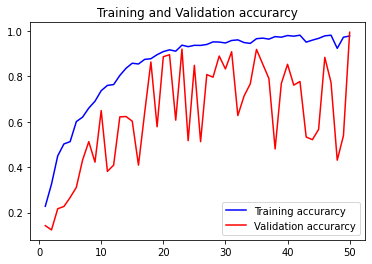

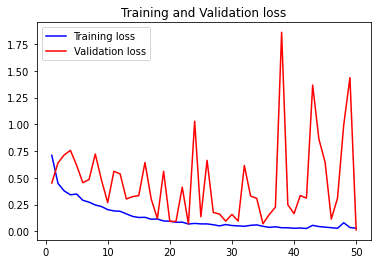

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
22/22 [==============================] - 14s 647ms/step - loss: 0.0130 - accuracy: 0.9942
Test Accuracy: 99.41775798797607


#### Save the Model 

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model_Final_1.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://bd85f037-9ad4-4305-a3b3-d90aa479ac13/assets


In [ ]:
model.save('cnn_model_1.h5')

In [ ]:
src = "/"
files=os.listdir(src)

#### Test if the Model is giving proper output

In [ ]:
from keras.models import load_model
model = load_model('/work/cnn_model_1.h5')

In [ ]:
import os
test = os.listdir('/work/images/images/Whitefish')
for i in range(len(test)):
    test[i] = '/work/images/images/Whitefish/' + test[i]

In [ ]:
len(test)

1548

In [ ]:
bream = 0
count = 1
for i in test:
    image_list = []
    image_list = (convert_image_to_array(i))
    np_image_list = np.array(image_list, dtype=np.float16) / 225.0
    np_image_list = tensorflow.reshape(np_image_list, shape=[-1, 256, 256, 3])
    result = model.predict(np_image_list)
    itemindex = np.where(result==np.max(result))

    list1 = ['Bream','Parkki','Perch','Pike','Roach','Smelt','Whitefish']
    #print("probability:"+str(np.max(result))+"\n"+list1[int(itemindex[1][0])])
    print('Done',count)
    count += 1
    if itemindex[1][0] == 6:
        bream += 1

Done 550
Done 551
Done 552
Done 553
Done 554
Done 555
Done 556
Done 557
Done 558
Done 559
Done 560
Done 561
Done 562
Done 563
Done 564
Done 565
Done 566
Done 567
Done 568
Done 569
Done 570
Done 571
Done 572
Done 573
Done 574
Done 575
Done 576
Done 577
Done 578
Done 579
Done 580
Done 581
Done 582
Done 583
Done 584
Done 585
Done 586
Done 587
Done 588
Done 589
Done 590
Done 591
Done 592
Done 593
Done 594
Done 595
Done 596
Done 597
Done 598
Done 599
Done 600
Done 601
Done 602
Done 603
Done 604
Done 605
Done 606
Done 607
Done 608
Done 609
Done 610
Done 611
Done 612
Done 613
Done 614
Done 615
Done 616
Done 617
Done 618
Done 619
Done 620
Done 621
Done 622
Done 623
Done 624
Done 625
Done 626
Done 627
Done 628
Done 629
Done 630
Done 631
Done 632
Done 633
Done 634
Done 635
Done 636
Done 637
Done 638
Done 639
Done 640
Done 641
Done 642
Done 643
Done 644
Done 645
Done 646
Done 647
Done 648
Done 649
Done 650
Done 651
Done 652
Done 653
Done 654
Done 655
Done 656
Done 657
Done 658
Done 659
Done 660
D